In [1]:
import torch
import numpy as np
import datasets
import os
import pandas as pd
import random
#import umap
import sys
import evaluate
import json
import seaborn as sns
import re
import nltk
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict, concatenate_datasets
from torch import nn
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Transformer, Pooling
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from IPython.core.debugger import Pdb, set_trace
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import util
#from tqdm.notebook import tqdm
from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from pprint import pprint
from scipy.cluster.hierarchy import linkage

from nbtools.utils import files, strings
from nbtools.sent_encoders import from_hf

datasets.disable_caching()

cache_dir = '/data/john/cache'
proot = files.project_root()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/data/john/projects/nb/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-27 00:32:39.353986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 00:32:40.035615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Categories

In [9]:
categories = {
    'Variable Management': [
        68411894, 56058221, 35083756, 72895360, 67601218, 36870894,
        35605603, 50201629, 63193710, 33348077, 69807973, 39867402,
        66636156, 67221899, 58046259, 35609093, 73575318, 73390904,
        51898227, 52240065, 69708522],
    'Networking': [
        26981907, 55900082, 63285502, 58754465, 66276506, 28606876,
        24269533, 53153531, 73582768, 71746669, 73360973, 57362807,
        62308248, 54818811, 40656740, 63717959],
    'Templating': [
        71612599, 43628823, 46927378, 44982029, 21908582, 42037814,
        40669728, 48080349, 62392584, 71515119, 51137660, 64977059,
        65363572, 61709093, 46971819],
    'Deployment Pipelines': [
        69044164, 31882621, 71483602, 32094916, 27971117, 32700029,
        33163204, 35220899, 55704077, 67705708, 69466012, 60722561,
        65826104, 35232088, 63688612, 63960211, 64731030, 66830226,
        67689553, 72114317],
    'Policy Configuration': [
        43065965, 36891271, 56041968, 62097373, 57615353, 62121904,
        43369041, 66446679, 55516699, 55696107, 51890092, 39922427,
        72492328, 74106418, 29075287, 34451477, 36520425, 36797901,
        36874322, 38250149, 44738112, 51214785, 54454259, 56120719,
        58108340, 61144484, 64379178, 74074710, 74671679, 29258759,
        46301925, 51314327],
    'Server Configuration': [
        63065263, 72785431, 60687917, 20040141, 20655700, 21346390,
        22395733, 22395733, 22395733, 26409164, 26597926, 28169407,
        28597029, 32103149, 38461920, 39622463, 41556574, 42506865,
        44045091, 44540690, 45495295, 55123912, 56536653, 56801517,
        58360322, 73293401, 59318382, 60650723, 61649293, 63704479,
        63970001, 64708469, 67600617, 68912007, 69017814, 70819513,
        73748528],
    'File Management': [
        23795117, 35271368, 37706756, 38073487, 40955440, 44134617, 45019429,
        47429168, 50276264, 54454306, 56622093, 59245525, 60503204, 62138666,
        62167266, 62443933, 63543523, 70677233,
    ]
}

# Load Data

In [10]:
# paths
base_path = '/data/john/files/iac/codellama_13b/20240426-131543'
res_path = f'{base_path}/benchmark_results.json'

# red dataset
ds = Dataset.from_json(res_path)
print(ds)

Dataset({
    features: ['task_id', 'temperature', 'inference_speed', 'llm', 'teler_level', 'index', 'results', 'score', 'pass'],
    num_rows: 283950
})


# Add Category Column

In [11]:
if 'category' not in ds.features.keys():
    cat_col = []
    for el in ds:
        for name, ids in categories.items():
            if el['task_id'] in ids:
                cat_col.append(name)
                break
    ds = ds.add_column('category', cat_col)
print(ds)



Dataset({
    features: ['task_id', 'temperature', 'inference_speed', 'llm', 'teler_level', 'index', 'results', 'score', 'pass', 'category'],
    num_rows: 283950
})


In [12]:
passed = ds.filter(lambda x: x['pass'] == 1)
print(passed)

Filter:   0%|          | 0/283950 [00:00<?, ? examples/s]

Filter: 100%|██████████| 283950/283950 [00:01<00:00, 189934.40 examples/s]

Dataset({
    features: ['task_id', 'temperature', 'inference_speed', 'llm', 'teler_level', 'index', 'results', 'score', 'pass', 'category'],
    num_rows: 60600
})


In [13]:
from collections import Counter

Filter:   0%|          | 0/283950 [00:00<?, ? examples/s]

Filter: 100%|██████████| 60600/60600 [00:01<00:00, 52678.77 examples/s]


Text(0.5, 1.0, 'Percentage of Correct Playbooks')

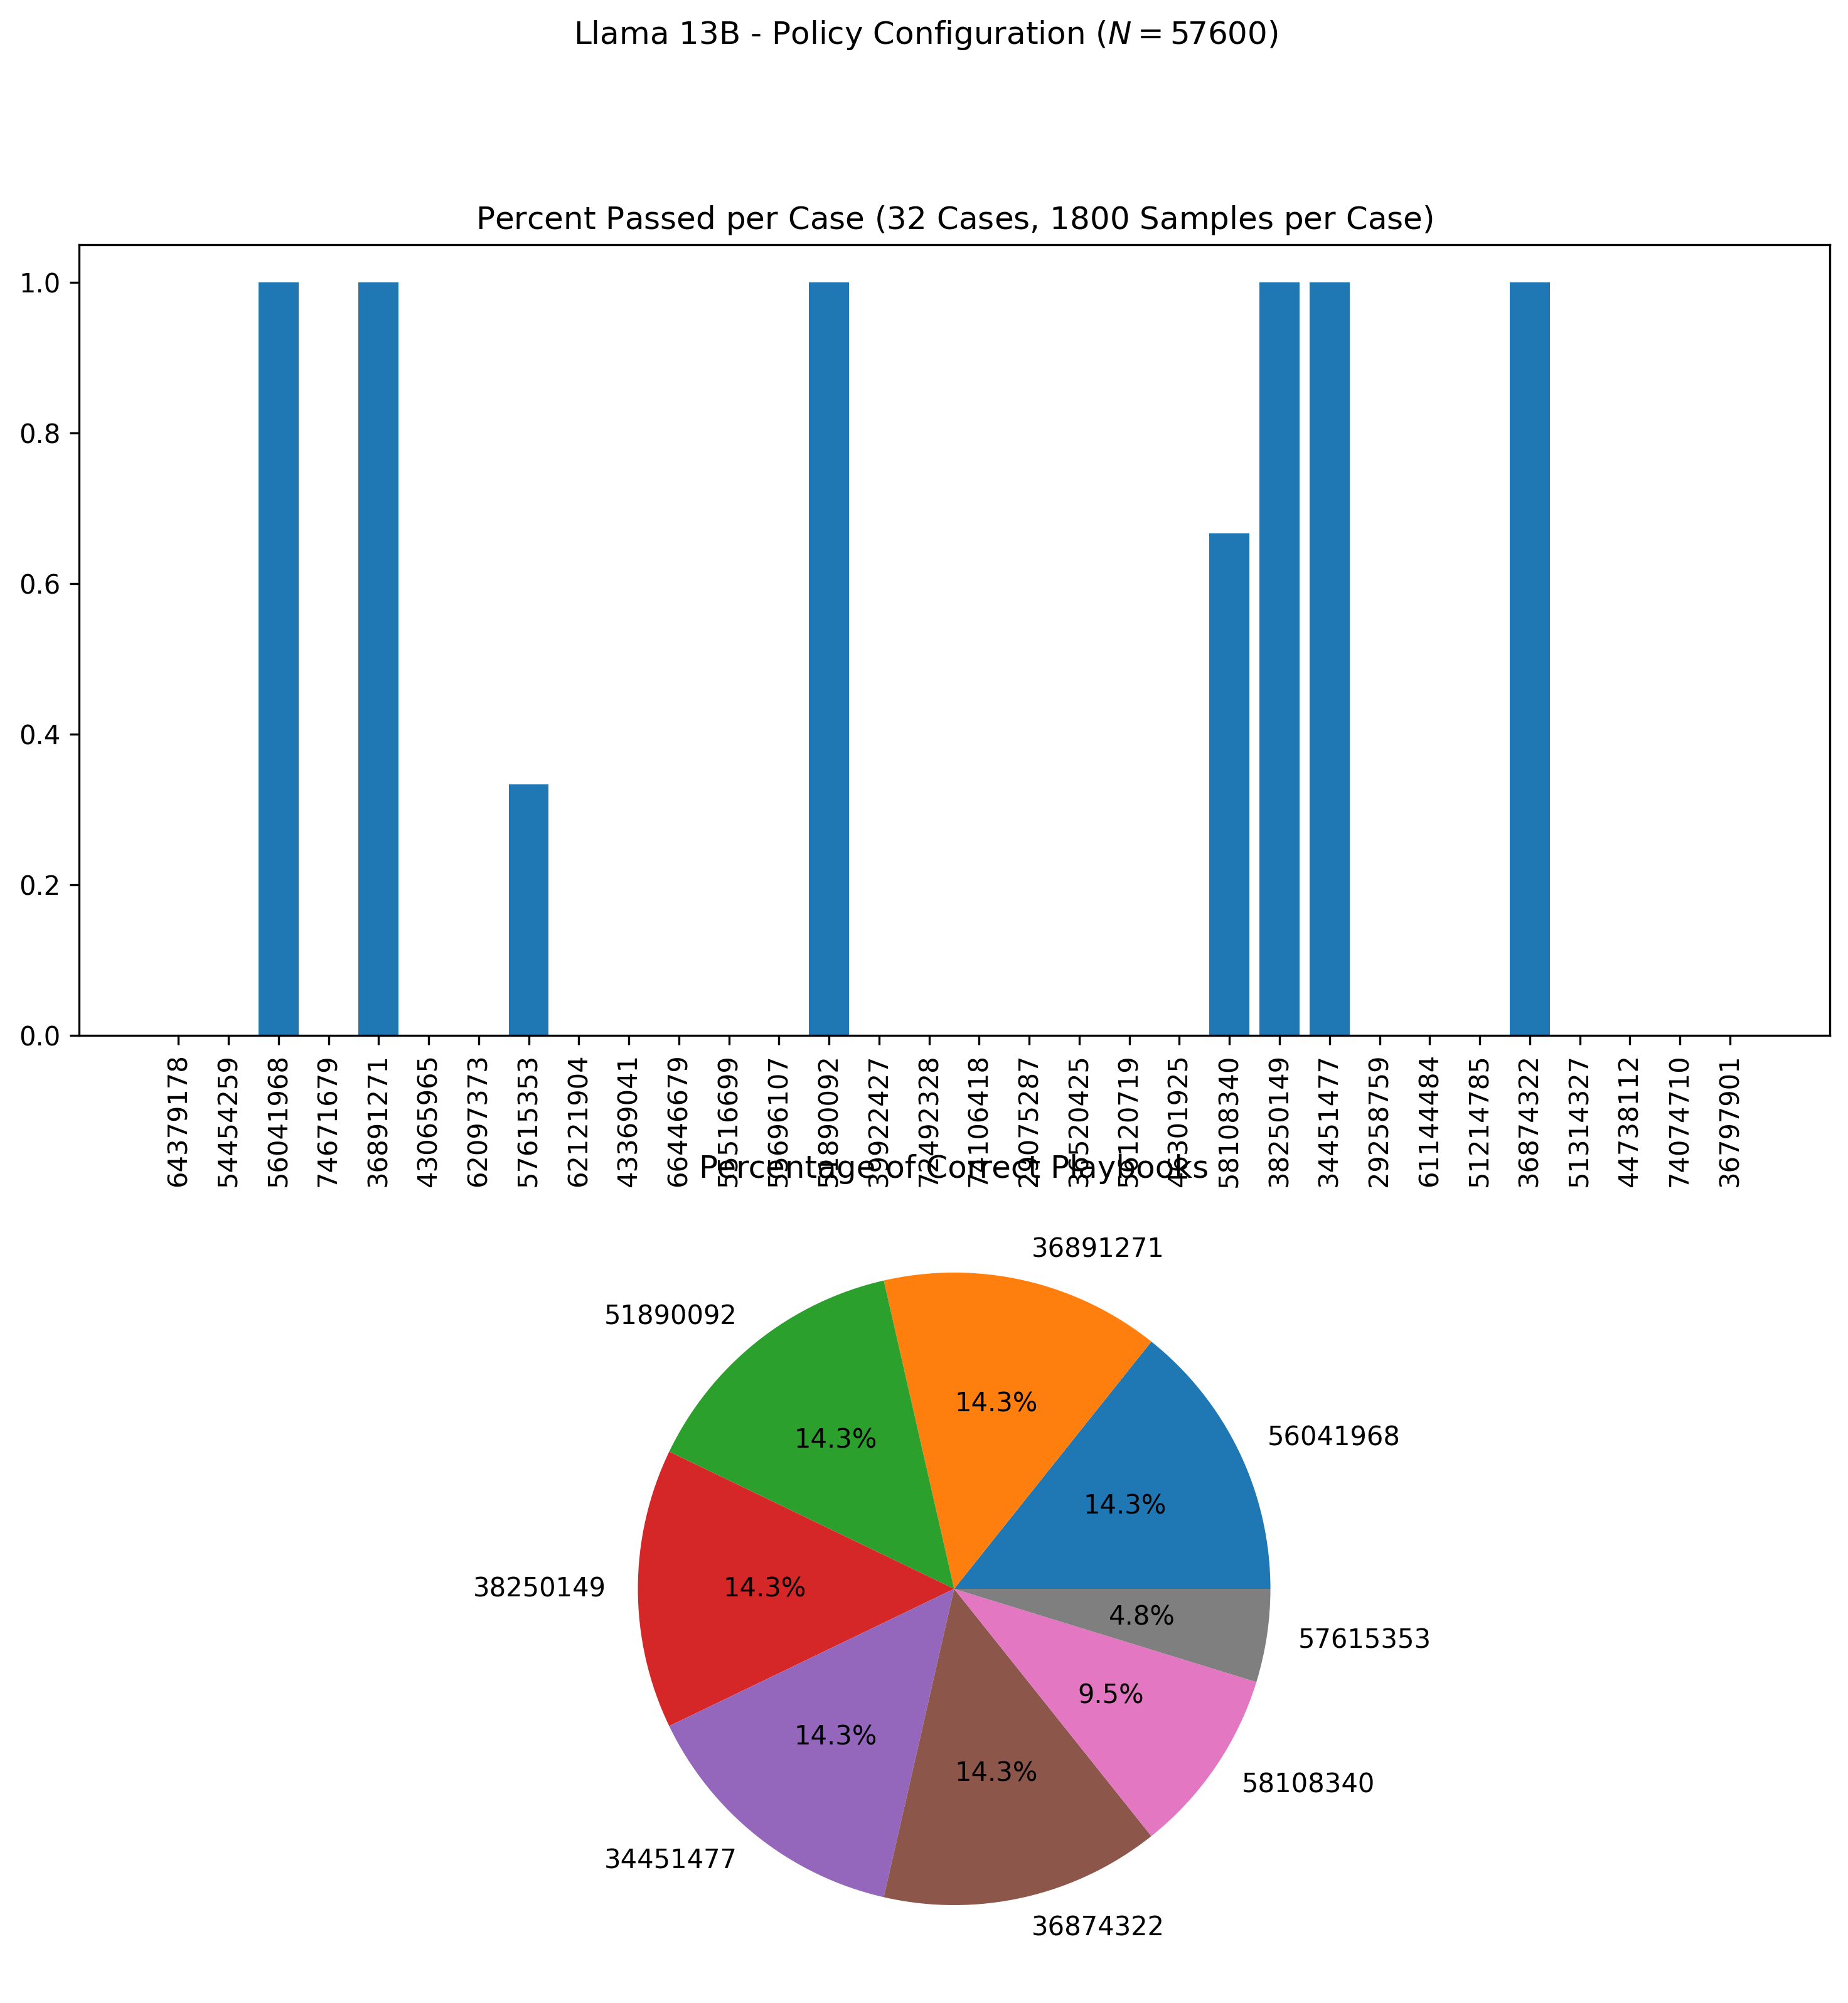

In [21]:
# Pick Category
cats = list(categories.keys())
cat = cats[4]

# Count
cat_all = ds.filter(lambda x: x['category'] == cat)
to_plot = passed.filter(lambda x: x['category'] == cat)
counts = Counter(to_plot['task_id'])
counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
totals = dict(Counter(cat_all['task_id']))
percent_passed = {key: counts.get(key, 0)/val for key, val in totals.items()}

# print percentages
fig, ax = plt.subplots(
    nrows=2,
    figsize=(15, 15), 
    dpi=300
)
fig.suptitle(f'Llama 13B - {cat} ($N={len(cat_all)}$)')
ax[0].bar(
    [str(x) for x in percent_passed],
    percent_passed.values(),
    width=0.8,
)
ax[0].set_title(f'Percent Passed per Case (${len(totals)}$ Cases, ${len(cat_all)//len(totals)}$ Samples per Case)')

ax[0].tick_params(axis='x', labelrotation=90)

ax[1].pie(
    counts.values(), 
    labels=counts.keys(),
    autopct='%1.1f%%',
)
ax[1].set_title(f'Percentage of Correct Playbooks')
